# **Discovering the Magic of Data Fusion: Privacy-First Record Linkage and More!** 🔗

Often, critical insights lie at the intersection of multiple datasets, possibly managed by different stewards or even external entities. Yet, often, we're faced with the daunting challenge of doing so while maintaining data privacy. So, when a direct peek into data is a no-go, how do we bridge the gaps?

This is where **Record Linkage** comes in. It allows you to connect multiple datasets without compromising privacy. This notebool unravels the importance of Record Linkage, especially when working with private datasets. 🤝🏼

1. **Indexing Methods Demystified:** 🔍 Dive deep into an array of indexing techniques. Discover not just the 'how' but also the 'when' of applying these methods, ensuring optimal data linkage.

2. **The Art of Comparison:** 🎨 Delve into different compare rules and grasp the nitty-gritty of how various comparison algorithms perform in real-life scenarios.

3. **Crafting Perfectly Linked Datasets:** 📊 Master the craft by deep diving on various indexing methods, compare rules and how to use them in real-world scenarios to create that perfectly linked dataset.

If you are eager to navigate through real-world challenges using the recordlinkage library and gain practical knowledge through hands-on examples, explore this notebook. 🤓

## **Getting Started: Install, Import & Connect to Antigranular**

In [ ]:

# Install antigranular client to your local machine.
!pip3 install antigranular
!pip3 install recordlinkage

In [3]:
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, competition = "Sandbox for Harvard Open DP Hackathon")

Loading dataset "Flight Company Dataset for Sandbox" to the kernel...
Dataset "Flight Company Dataset for Sandbox" loaded to the kernel as flight_company_dataset_for_sandbox
Loading dataset "Health Organisation Dataset for Sandbox" to the kernel...
Dataset "Health Organisation Dataset for Sandbox" loaded to the kernel as health_organisation_dataset_for_sandbox
Connected to Antigranular server session id: f9106c6f-449f-4556-9d18-9abd5743b64f, the session will time out if idle for 60 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


# **Initialisation**

Setting up some utility functions and a local recordlinkage database which we will be importing into Antigranular environment.

In [ ]:
import recordlinkage as rl
from recordlinkage.datasets import load_febrl4
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt


dfA = {
  'ID':[i for i in range(5)],
  'names':['john','james','arthur','raj','kenny'],
  'country':['england','usa','england','india','usa'],

}

dfB = {
  'ID':[i for i in range(6,11)],
  'names':['jon','arthur','mathew','raj','keny'],
  'country':['england','ireland','england','india','usa']
}



dfA = pd.DataFrame(dfA).set_index('ID')
dfB = pd.DataFrame(dfB).set_index('ID')
large_dfA , large_dfB = load_febrl4()


def plot_graph(edges):
  G = nx.Graph()
  G.add_edges_from(edges)
  blue_nodes = list(set([x for x, y in edges]))
  red_nodes = list(set([y for x, y in edges]))
  pos = {}
  for i, node in enumerate(blue_nodes):
    pos[node] = (-1, i)
  for i, node in enumerate(red_nodes):
    pos[node] = (1, i)

  nx.draw_networkx_nodes(G, pos, nodelist=blue_nodes, node_color='blue', label='dfA')
  nx.draw_networkx_nodes(G, pos, nodelist=red_nodes, node_color='red', label='dfB')
  nx.draw_networkx_edges(G, pos)
  nx.draw_networkx_labels(G, pos)
  plt.legend()

  plt.show()



In [ ]:
dfA.head()

,names,country
ID,,
0,john,england
1,james,usa
2,arthur,england
3,raj,india
4,kenny,usa


In [ ]:
dfB.head()

,names,country
ID,,
6,jon,england
7,arthur,ireland
8,mathew,england
9,raj,india
10,keny,usa


Use `private_import` method to send local data into Antigranular session.

In [ ]:
session.private_import(name='dfA' ,data=dfA)
session.private_import(name='dfB',data=dfB)
session.private_import(name='large_dfA',data=large_dfA)
session.private_import(name='large_dfB',data=large_dfB)

dataframe cached to server, loading to kernel...
Output: Dataframe loaded successfully to the kernel

dataframe cached to server, loading to kernel...
Output: Dataframe loaded successfully to the kernel

dataframe cached to server, loading to kernel...
Output: Dataframe loaded successfully to the kernel

dataframe cached to server, loading to kernel...
Output: Dataframe loaded successfully to the kernel



Converting the imported dataframes to `PrivateDataFrame` so that we can use private recordlinkage library.

In [ ]:
%%ag
import op_pandas
pdfA = op_pandas.PrivateDataFrame(dfA)
pdfB = op_pandas.PrivateDataFrame(dfB)
large_pdfA = op_pandas.PrivateDataFrame(large_dfA)
large_pdfB = op_pandas.PrivateDataFrame(large_dfB)

 ## **Preprocessing in Record Linkage** 🌐
### recordlinkage.preprocessing.clean()

The `recordlinkage.preprocessing.clean` function is a comprehensive tool in the Python Record Linkage Toolkit designed to preprocess and clean string data. This function facilitates the cleaning of strings by removing undesired tokens, whitespace, brackets, and more, making the data more consistent and suitable for linkage or comparison tasks.

Imagine you have a dataset with location names, but the names have various formats, spellings, and unwanted characters. Before comparing or linking this dataset with another, you'd want to standardise these names for accuracy. Using the clean function, you can efficiently preprocess the data to a consistent format.


In [ ]:
from recordlinkage.preprocessing import clean
names = ["Mr. Smith", "Smyth", "Dr. garsia", "Mr. Garcia", "mC Donald", "Dr. MacDonald"]
name_series = pd.Series(names)
name_series = clean(name_series, lowercase=True , replace_by_whitespace=r"(mr|dr)")

name_series

0        smith
1        smyth
2       garsia
3       garcia
4    mc donald
5    macdonald
dtype: object

### recordlinkage.preprocessing.phonetic

The `recordlinkage.preprocessing.phonetic` function is used for converting strings into their phonetic codes. Phonetic algorithms, like Soundex, index words based on their pronunciation. This can be especially useful when dealing with names that might have multiple spellings but sound similar. Converting strings into phonetic codes can help in identifying similar-sounding words, even if they are spelled differently.

Imagine you're working with a dataset containing names from oral interviews. Names like "Smith" might be spelled in various ways, such as "Smyth" or "Smithe". The phonetic function can convert these names into a common code, making it easier to identify and link similar-sounding entries.

In [ ]:
from recordlinkage.preprocessing import phonetic
phonetic(name_series,method='soundex')

0    S530
1    S530
2    G620
3    G620
4    M235
5    M235
dtype: object

# **Indexing in Record Linkage** 🧐

The indexing module is used to create pairs of records. These pairs are known as candidate links or candidate matches. Several indexing algorithms, such as full, random, blocking, and sorted neighbourhood indexing, are used for both linking and deduplication purposes.

**Why You Should Use Indexing:**

1. **Efficiency:** Without indexing, the process would involve comparing every record in one dataset with every record in another dataset (or with all other records in the same dataset for deduplication). This can be computationally intensive. Indexing reduces the number of comparisons by eliminating obvious non-matches.

2. **Accuracy:** Some indexing methods, especially those that take advantage of specific data characteristics, can improve the quality of candidate links by focusing on more probable matches.

3. **Scalability:** For large datasets, indexing is almost a necessity. It allows the record linkage process to be feasible even with millions of records.

**How Indexing Should Be Done:**

1. **Understand Your Data:** Before choosing an indexing method, it's crucial to understand the characteristics of your data. For instance, do you have a unique identifier? Are there common fields that can be used for blocking?

2. **Choose the Right Method:** Not all indexing methods are suitable for all types of data. For instance, blocking might be more efficient when there's a common field between datasets, while sorted neighbourhood indexing can be better for datasets with slight variations in values.

3. **Quality Over Quantity:** It's better to have fewer high-quality candidate links than numerous low-quality ones. Adjust the parameters of your indexing method to ensure that the candidates are probable matches.

4. **Iterate and Refine:** Indexing is often an iterative process. As you test and refine your linkage strategy, you may need to adjust your indexing method or parameters to improve results.



### **Full Indexing**

Full indexing, often termed as "full cartesian product indexing", creates candidate links by forming all possible unique combinations between records in one dataset and those in another dataset. Essentially, every record in the first dataset is compared to every record in the second dataset.

**When to Use It:**
1. **Small Datasets:** Full indexing is most feasible and practical when both datasets are relatively small. Given its exhaustive nature, the number of comparisons grows significantly with the size of the datasets.

2. **Absence of Common Attributes:** When datasets lack distinct common attributes that can be used for more efficient indexing methods like blocking or sorted neighbourhood indexing, full indexing might be the most straightforward approach.

3. **Maximising Match Opportunities:** Full indexing ensures that no potential matches are overlooked. This makes it ideal when aiming for completeness of potential matches, regardless of computational cost.


In [ ]:
%%ag
import op_recordlinkage as rl
indexer = rl.Index()
indexer.full()
links = indexer.index(pdfA,pdfB)
ag_print(f"Total number of links in full indexing : {links.count(eps=1)}")


Total number of links in full indexing : 26



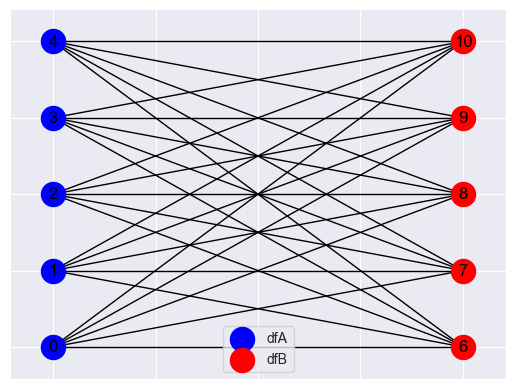

In [ ]:
# LOCAL environment | Graphical representation of Full Indexing.
indexer = rl.Index()
indexer.full()
links = indexer.index(dfA,dfB)
links = list(links)
plot_graph(links)

### **Block Indexing**

Block indexing, often simply referred to as "blocking", is an indexing method used in record linkage. In this method, records are partitioned into distinct groups or "blocks", based on one or more key attributes. Only records within the same block are compared, thus significantly reducing the number of comparisons required. The key attribute(s) used for blocking should have a high probability of being the same for true matches.


**When to Use It:**
1. **Large Datasets:** Blocking is particularly effective when dealing with large datasets. By reducing the number of comparisons, blocking makes the linkage process more scalable and efficient.

2. **Common Key Attributes:** Blocking is suitable when there's a common field or attribute across the datasets that is likely to be consistent for true matches, such as postal code, birth year, or initial letters of a name.

3. **Balance Between Efficiency and Completeness:** While blocking greatly improves efficiency, it may miss some true matches if they are in different blocks. Thus, it's ideal when seeking a balance between computational efficiency and match completeness.


In [ ]:
%%ag
import op_recordlinkage as rl
indexer = rl.Index()
indexer.block('names','names')
links = indexer.index(pdfA,pdfB)
ag_print(f"Total number of links in block indexing : {links.count(eps=1)}")


Total number of links in block indexing : 0



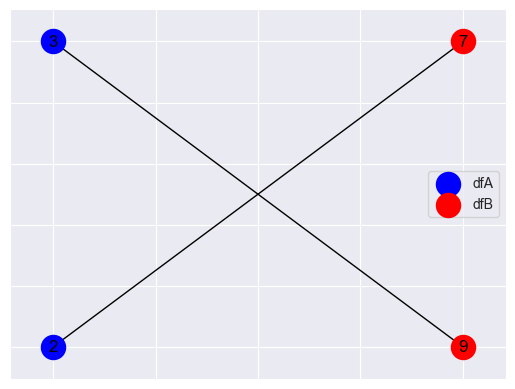

In [ ]:
# LOCAL environment | Graphical representation of Block Indexing
indexer = rl.Index()
indexer.block('names','names')
links = indexer.index(dfA,dfB)
links = list(links)
plot_graph(links)

Adding more blocking rules allows you to obtain more potential candidate links based on the new rule and increases the number of pairs satisfying either of the block rules.

In [ ]:
%%ag
import op_recordlinkage as rl
indexer = rl.Index()
indexer.block('country','country')
indexer.block('names','names')
links = indexer.index(pdfA,pdfB)
ag_print(f"Total number of links in block indexing : {links.count(eps=1)}")

Total number of links in block indexing : 7



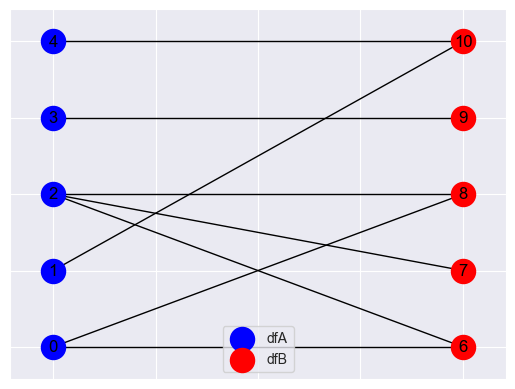

In [ ]:
# LOCAL environment | Graphical representation of block indexing
indexer = rl.Index()
indexer.block('country','country')
indexer.block('names','names')
links = indexer.index(dfA,dfB)
links = list(links)
plot_graph(links)


### **Sorted-Neighbourhood Indexing**

Sorted-neighbourhood indexing is a method used in record linkage, especially when dealing with noisy data or slight variations in data entries. In this approach, records are first sorted based on a specific key attribute. Once sorted, a window of a specified size slides through the sorted list. Only records that fall within this window are considered as candidate pairs for comparison. This method assumes that true matches are likely to be near each other in the sorted order, even if they aren't exactly identical due to errors or variations.

**When to Use It:**
1. **Noisy Data:** Sorted-neighbourhood indexing is particularly effective when data has inconsistencies, such as minor spelling variations, typographical errors, or abbreviations. Traditional blocking might fail to group such near-matches together, but they are likely to be close in a sorted list.

2. **Unknown Errors and Variations:** If you're unsure about the types and extents of errors in your dataset, sorted-neighbourhood indexing can be a safer bet than simple blocking, since it accommodates slight variations in the key attribute.

3. **Balancing Efficiency and Completeness:** While the sorted-neighborhood method can lead to more comparisons than simple blocking (depending on the window size), it can be less exhaustive than full indexing. It provides a balance between efficiency and the risk of missing potential matches.

4. **Adaptable Window Size:** The window size can be adjusted based on the quality of data and desired trade-off between computational cost and likelihood of capturing matches. A larger window will capture more potential matches but will also require more comparisons.


In [ ]:
%%ag
import op_recordlinkage as rl
indexer = rl.Index()
indexer.sortedneighbourhood('names','names')
links = indexer.index(pdfA,pdfB)
ag_print(f"Total number of links using sorted neighbourhood: {links.count(eps=1)}")

Total number of links using sorted neighbourhood: 8



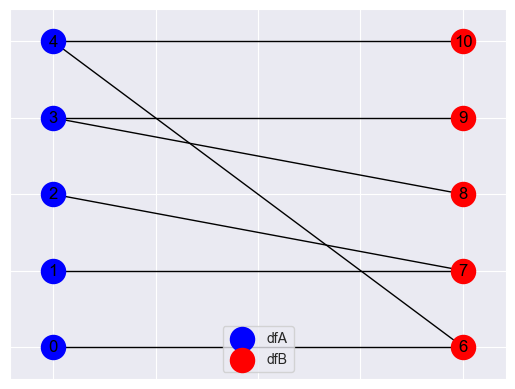

In [ ]:
# LOCAL environment | Graphical representation of Sortedneighbourhood indexing
indexer = rl.Index()
indexer.sortedneighbourhood('names','names')
links = indexer.index(dfA,dfB)
links = list(links)
plot_graph(links)

### **Random Indexing**

Random indexing is a method used in record linkage where pairs of records are selected at random to form candidate links. Instead of performing exhaustive comparisons or using structured rules (as in blocking or sorted-neighbourhood methods), this method relies on random sampling to generate a subset of potential matches. It offers a stochastic approach to the problem of identifying candidate record pairs.

**When to Use It:**
1. **Exploratory Analysis:** If you're initially trying to gauge the quality of matches between two datasets without diving deep into detailed comparisons, random indexing can give you a quick, albeit approximate, view.

2. **Large Datasets:** When dealing with exceedingly large datasets, even efficient methods like blocking might be computationally intensive. Random indexing can provide a quick way to generate a subset of candidate links for preliminary analysis.

3. **Absence of Clear Blocking Key:** If the datasets do not have clear attributes for blocking or if the quality of data is uncertain, random indexing can serve as a starting point before deciding on more structured approaches.

4. **Balancing Computational Cost:** While random indexing might miss many potential matches, it allows for a reduction in computational cost. It's a trade-off between efficiency and completeness.

5. **Benchmarking:** Random indexing can be used as a baseline method to benchmark the effectiveness of other more sophisticated record linkage methods.


In [ ]:
%%ag
import op_recordlinkage as rl
indexer = rl.Index()
indexer.random(n = 10)
links = indexer.index(pdfA,pdfB)
ag_print(f"Total number of links in random indexing : {links.count(eps=1)}")

Total number of links in random indexing : 7



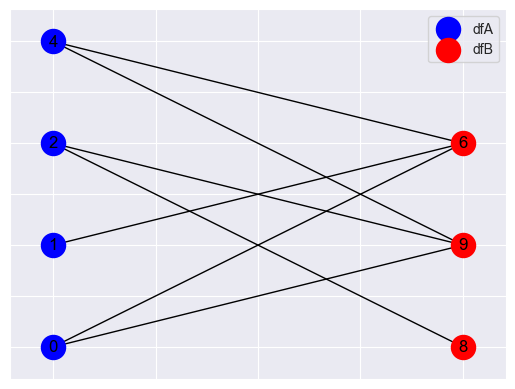

In [ ]:
# LOCAL environment | Graphical representation of Random indexing
indexer = rl.Index()
indexer.random(n = 10)
links = indexer.index(dfA,dfB)
links = list(links)
plot_graph(links)


## **Comparing in Record Linkage** ⚖️

Comparing refers to the process of assessing pairs of records to determine how similar they are across various attributes or fields. Once potential candidate pairs are identified (using methods like blocking, sorted-neighbourhood indexing, or full indexing), these pairs undergo a comparison to produce a similarity score. This score is then used to decide if the pair is a true match or not.

The comparison can involve:

1. **Exact Matching:** Checking if the values in the fields are exactly the same.

2. **Fuzzy Matching:** Using algorithms to determine the similarity between values. This is especially useful for textual data where typos or different representations might exist (e.g., "Jon" vs. "John").

3. **Numeric or Date Comparisons:** For numeric or date fields, differences can be computed directly or categorizsd into bands (e.g., age difference of less than 5 years, between 5 and 10 years, etc.).

4. **Custom Comparisons:** Depending on domain-specific knowledge, custom comparison functions can be employed. For example, in a medical context, two different codes might represent the same condition, and a custom function can identify them as a match.

**Significance:**
Comparing is a crucial step in record linkage as it directly influences the quality of the linkage. Accurate comparisons ensure that true matches are identified while minimising false positives (incorrectly identified matches) and false negatives (missed true matches).

<br/>
<br/>

Let's learn more about various comparison rules using a larger dataset.
I have loaded them under the name `large_pdfA` and `large_pdfB` into the Antigranular server.


In [ ]:
# LOCAL environment
large_dfA

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688
...,...,...,...,...,...,...,...,...,...,...
rec-2153-org,annabel,grierson,97,mclachlan crescent,lantana lodge,broome,2480,nsw,19840224,7676186
rec-1604-org,sienna,musolino,22,smeaton circuit,pangani,mckinnon,2700,nsw,19890525,4971506
rec-1003-org,bradley,matthews,2,jondol place,horseshoe ck,jacobs well,7018,sa,19481122,8927667


In [ ]:
# LOCAL environment
large_dfB

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-561-dup-0,elton,NaN,3,light setreet,pinehill,windermere,3212,vic,19651013,1551941
rec-2642-dup-0,mitchell,maxon,47,edkins street,lochaoair,north ryde,3355,nsw,19390212,8859999
rec-608-dup-0,NaN,white,72,lambrigg street,kelgoola,broadbeach waters,3159,vic,19620216,9731855
rec-3239-dup-0,elk i,menzies,1,lyster place,NaN,northwood,2585,vic,19980624,4970481
rec-2886-dup-0,NaN,garanggar,NaN,may maxwell crescent,springettst arcade,forest hill,2342,vic,19921016,1366884
...,...,...,...,...,...,...,...,...,...,...
rec-4495-dup-0,connor,belperio,15,NaN,NaN,ryde,2570,nsw,19170518,5394641
rec-4211-dup-0,daniel,maspn,9,derrington crescent,el pedro caravan park,sunnybank,4350,vic,19500705,5525378
rec-3131-dup-0,samuel,crofs,613,banjine street,kurrajong vlge,pengzin,2230,qld,19410531,4467228


Setting up an indexing rule to generate candidate links on which we can further filter using various comparison rules.

In [ ]:
%%ag
import op_recordlinkage as rl
# Applying block indexing against some of the
indexer = rl.Index()
indexer.block(left_on='date_of_birth',right_on='date_of_birth')
indexer.block(left_on='postcode',right_on='postcode')
links = indexer.index(large_pdfA,large_pdfB)
ag_print(f"Total number of candidate links = {links.count(eps=0.1)}")

Total number of candidate links = 29955



In [ ]:
# LOCAL environment | Setting up the candidate links locally for testing purpose.
indexer = rl.Index()
indexer.block(left_on='date_of_birth',right_on='date_of_birth')
indexer.block(left_on='postcode',right_on='postcode')
links = indexer.index(large_dfA,large_dfB)

### **Exact Compare Rule**

The exact compare rule in record linkage refers to a method where two fields or attributes from different records are compared to determine if they are exactly the same. This means that the values must match character for character, with no deviations. If the two fields are identical, the comparison yields a match; otherwise, it does not.

**When to Use It:**
1. **High-Quality Data:** When you're confident about the consistency and accuracy of the data, and there's no room for typos, abbreviations, or variations.

2. **Unique Identifiers:** For fields that contain unique identifiers such as Social Security Numbers, employee IDs, or product codes. In these cases, even a single character difference indicates distinct entities.

3. **Binary or Categorical Data:** Fields with a limited set of values, like gender (Male/Female) or a Yes/No flag.

4. **Consistent Formatting:** When you're certain that data formats are consistent across datasets, such as date fields always being in the "YYYY-MM-DD" format.

5. **Performance Considerations:** Exact matching is typically faster than fuzzy matching, so if computational efficiency is a concern and the data's nature permits, exact matching can be a good choice.


In [ ]:
%%ag
compare = rl.Compare()
compare.exact(left_on='soc_sec_id',right_on='soc_sec_id',label='social_compare')
compare.exact(left_on='given_name',right_on='given_name',label='name_compare')
compare.exact(left_on='address_1',right_on='address_1',label='address_compare')
features = compare.compute(links,large_pdfA,large_pdfB)
ag_print(features.mean(eps=1))

social_compare     0.150158
name_compare       0.110865
address_compare    0.098540
dtype: float64



In [ ]:
# LOCAL environment | Showing how the features matrix looks as a non-private dataframe.
compare = rl.Compare()
compare.exact(left_on='soc_sec_id',right_on='soc_sec_id',label='social_id')
compare.exact(left_on='given_name',right_on='given_name',label='name')
compare.exact(left_on='address_1',right_on='address_1',label='address')
features = compare.compute(links,large_dfA,large_dfB)
features

social_id  name  address
rec_id_1    rec_id_2                                
rec-0-org   rec-0-dup-0             1     1        1
            rec-2526-dup-0          0     0        0
rec-1-org   rec-1-dup-0             1     1        0
            rec-451-dup-0           0     0        0
rec-10-org  rec-10-dup-0            1     0        1
...                               ...   ...      ...
rec-999-org rec-1916-dup-0          0     0        0
            rec-2424-dup-0          0     0        0
            rec-3472-dup-0          0     0        0
            rec-3537-dup-0          0     0        0
            rec-999-dup-0           1     1        1

[29959 rows x 3 columns]

### **String Compare Rule**


1. `jaro`:
   - Measures the similarity between two strings. It accounts for characters in common and the number of transpositions between the two strings.
   - **Use-case**: Effective for shorter strings, such as names.

2. `jarowinkler`:
   - An extension of the Jaro similarity metric. It's more favourable to strings that match from the beginning. A prefix scale is applied which gives more favourable ratings to strings that match from the start.
   - **Use-case**: Especially beneficial for personal names where prefixes can be crucial.

3. `levenshtein`:
   - Calculates the minimum number of single-character edits (i.e., insertions, deletions, or substitutions) to change one word into the other.
   - **Use-case**: Useful for fields that might have minor typos or misspellings.

4. `damerau_levenshtein`:
   - A variant of the Levenshtein distance. It allows transpositions (switches of two adjacent characters) alongside the usual edits.
   - **Use-case**: Efficient for capturing common typing errors where two neighboring characters are accidentally swapped.

5. `qgram`:
   - The Q-gram method divides strings into overlapping substrings of length `q` (often 2, called bigrams). The similarity score then relies on the count of shared q-grams between the two strings.
   - **Use-case**: Suitable for longer text fields, capturing more contextual similarities.

6. `cosine`:
   - Cosine similarity measures the cosine of the angle between two vectors. In the context of text, these vectors can be formed by term frequency (like bag-of-words).
   - **Use-case**: Effective for comparing longer texts or when the order of words isn't critical.

7. `smith_waterman`:
   - A local sequence alignment method that identifies the optimal local alignments by ignoring the more divergent sections.
   - **Use-case**: Suitable when comparing sequences where parts of the sequence are believed to be more relevant than the entirety.

8. `lcs`:
   - **Description**: Measures the longest sequence of characters that are common between two strings without considering the positions of characters in terms of the entire string.
   - **Use-case**: Useful when there are substrings in common, but scattered throughout the string.

When choosing a string similarity algorithm, the nature of the data and the specific application play critical roles. To get optimal matching results, it's often beneficial to experiment with various algorithms and even combine them, adjusting their weights.

In [ ]:
%%ag
compare = rl.Compare()
compare.string(left_on='address',right_on='address_1',label='address_1',method='cosine')
compare.string(left_on='given_name',right_on='given_name',label='name',method='jaro')
features = compare.compute(links,large_pdfA,large_pdfB)


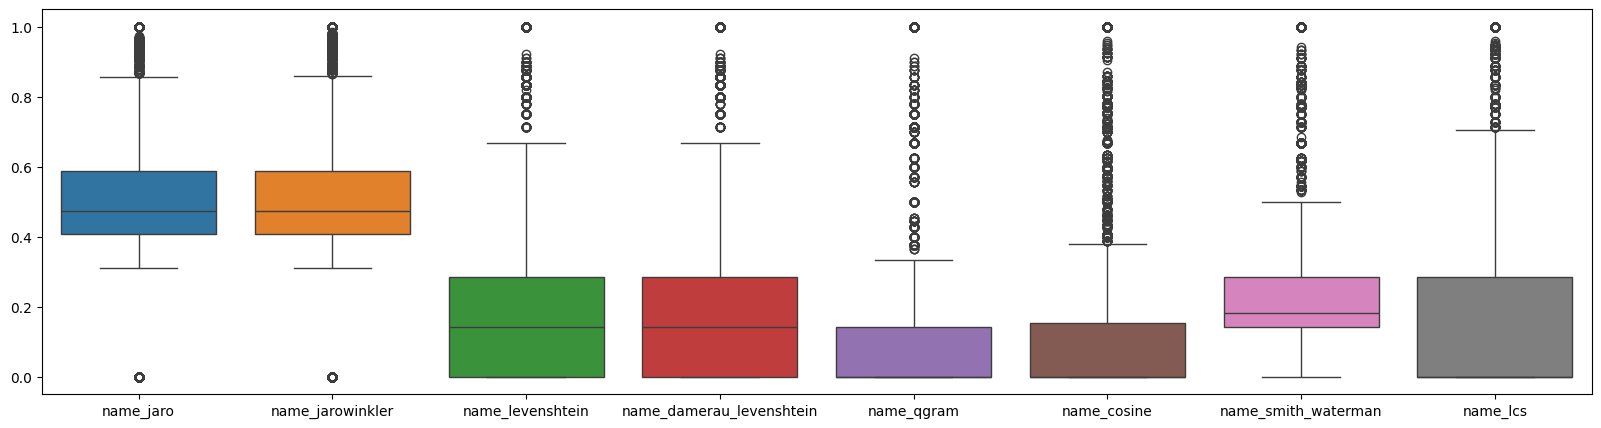

In [ ]:
# LOCAL environment | Evaluating various string compare algorithms against names.
algorithms = ['jaro' , 'jarowinkler','levenshtein','damerau_levenshtein','qgram','cosine','smith_waterman','lcs']

compare_names = rl.Compare()
for i in algorithms:
  compare_names.string(left_on='given_name',right_on='given_name',label='name_'+i,method=i)
feature_names = compare_names.compute(links,large_dfA,large_dfB)
plt.figure(figsize=(20,5))
sns.boxplot(data=feature_names)
plt.show()

Plotting the ranges of weights obtained for each algorithm. We can see that `jaro` and `jarowinkler` has better average matching score compared to other algorithms. Hence , they are good for matching with some margin of error. Other algorithms are more strict with respect to the matching scores obtained and seem to better for strict matching.

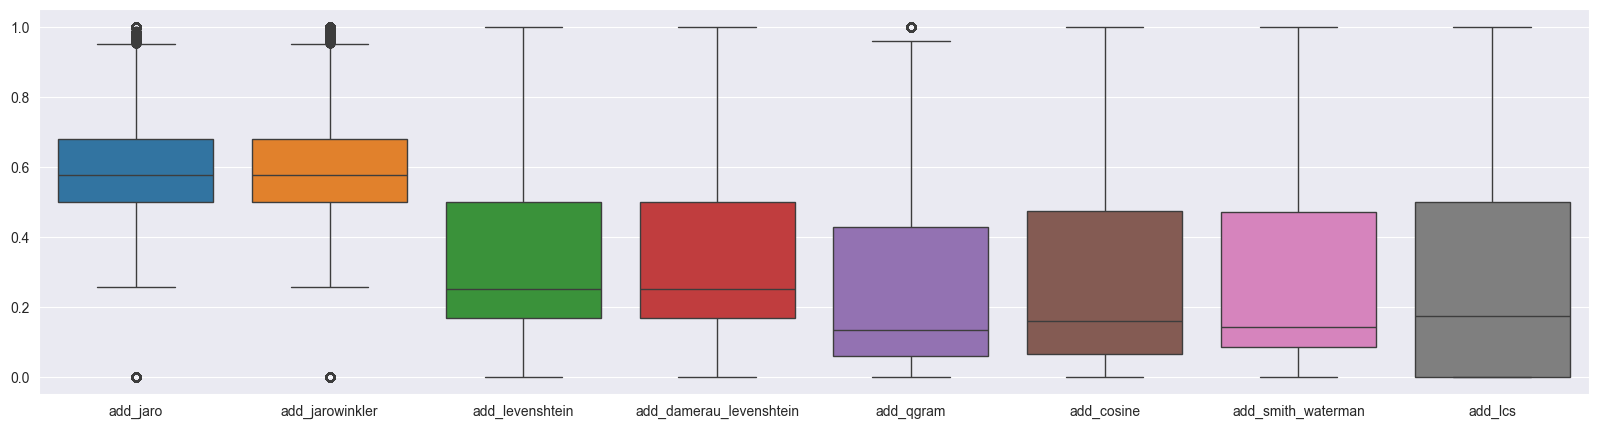

In [ ]:
# LOCAL environment | Evaluating various string compare algorithms against addresses.
algorithms = ['jaro' , 'jarowinkler','levenshtein','damerau_levenshtein','qgram','cosine','smith_waterman','lcs']

compare_address = rl.Compare()
for i in algorithms:
  compare_address.string(left_on='address_1',right_on='address_1',label='add_'+i,method=i)
feature_address = compare_address.compute(links,large_dfA,large_dfB)

plt.figure(figsize=(20,5))
sns.boxplot(data=feature_address)
plt.show()

## **Other compare rules**

### Compare.numeric()
This class is used to compare numeric values.
1. **Step Function (`'step'`)**:
    - This function assigns a similarity of 1 if the absolute difference between two numbers is less than a specified offset. Otherwise, it assigns a similarity of 0. It's a sharp cutoff, meaning that small deviations in the numeric values can yield a similarity of 0.

2. **Linear Function (`'linear'`)**:
    - The similarity decreases linearly with the absolute difference between two numbers. The function starts at 1 (for identical values) and linearly decreases to 0 as the difference increases. You can control the rate of decline by adjusting the `scale` parameter.

3. **Exponential Function (`'exp'`)**:
    - This function decreases the similarity exponentially based on the absolute difference between two numbers. The rate of decrease can be controlled by the `scale` parameter.

4. **Gaussian Function (`'gauss'`)**:
    - The similarity is calculated based on the Gaussian (normal) distribution. The function gives a similarity of 1 for identical values, and the similarity diminishes in a bell curve manner as the difference increases.

5. **Squared Function (`'squared'`)**:
    - Similar to the exponential function, but the decrease in similarity is based on the square of the difference between two numbers.

![](https://recordlinkage.readthedocs.io/en/latest/_images/elas_1705.png)

Parameters to be aware of:

- **offset**: Defines the absolute difference below which two numbers are considered similar (for the step function).
- **scale**: Controls the rate of decline in similarity for the linear, exponential, and Gaussian functions.
- **origin**: The center of the similarity function. For the step function, it defines the point at which the similarity drops from 1 to 0.
- **missing_value**: The value to assign when a comparison involves a missing value.

### Compare.geo()
The `recordlinkage.compare.geo()` is designed to evaluate the similarity between two geographic locations specified by their WGS84 coordinates (latitude and longitude). This method takes into account the Earth's curvature and computes the haversine distance, which calculates the shortest distance between two points on the surface of a sphere. This makes it suitable for comparing real-world geographical coordinates.

The similarity algorithms are ‘step’, ‘linear’, ‘exp’, ‘gauss’ or ‘squared’. The similarity functions are the same as in `recordlinkage.Compare.numeric()`

<br/>

### Compare.date()
The `recordlinkage.compare.date()`  is devised to compute the similarity between two date values, especially focusing on common errors and discrepancies observed in date records. These discrepancies can be due to human errors, typos, or certain automated data entry systems.

Key Features:
- **Handling Month-Day Swap**: The class can account for situations where the day and month in a date might have been swapped, which is a common mistake in data entry.
- **Handling Month Number Translation Errors**: The class can also handle errors that arise when months are translated into numbers. For instance, mistakenly translating "October" as "9" instead of "10".




## **Custom Comparison**

`recordlinkage` allows for custom comparison functions tailored to specific needs. It offers a way to define any function that computes a similarity score based on two input values (one from each dataset to be compared).

### Why use a custom comparison method:

1. **Flexibility**: Built-in algorithms may not capture the nuances of all datasets. Custom comparisons allow you implement specific logic relevant to your data.

2. **Domain-Specific Comparisons**: In certain domains, data might have specialised rules or formats that generic algorithms can't address effectively.

3. **Complex Attribute Relationships**: Sometimes, you might need to consider multiple attributes in tandem to determine similarity, which a generic method might not capture.

### Example Use Cases:

1. **Phonetic Similarity in Names**: While there are standard algorithms like Soundex or Metaphone for phonetic comparisons, you might have a custom phonetic algorithm tailored for a specific language or dialect.

2. **Special Date Formats**: If you're working with unique date formats or calendar systems, like fiscal calendars, you might need a custom comparison.

3. **Custom Weighting Systems**: Suppose you want to compare products based on multiple attributes, like price, brand, and features. A custom function can weigh these attributes differently to produce a composite similarity score.

4. **Domain-Specific Jargon**: In certain industries, there might be domain-specific jargon or abbreviations. A custom function can handle these peculiarities better.

In essence, the custom comparison method in `recordlinkage` is a flexible tool that comes into play when there's a need for specialised comparison logic or when working with unique data domains.

In [ ]:
%%ag
compare = rl.Compare()

# Here's a basic custom function to compare names
def cmp( name1 : str , name2 : str ) -> float:
  if not isinstance(name1,str):
    return 0.0
  if not isinstance(name2,str):
    return 0.0
  # Convert both names to lowercase for a case-insensitive comparison
  name1 = name1.lower()
  name2 = name2.lower()

  # Exact match
  if name1 == name2:
    return 1.0

  # Initial check: E.g. "A. Smith" and "Adam Smith"
  if name1[0] == name2[0] and (name1[1] == '.' or name2[1] == '.'):
    return 0.9

  # Substring check: E.g. "Rob" and "Robert"
  if name1 in name2 or name2 in name1:
    return 0.8

  # Length difference: E.g. "Ann" and "Anne"
  if abs(len(name1) - len(name2)) == 1:
    return 0.7

  return 0.0


compare.custom(cmp,left_on='given_name',right_on='given_name',label='name_compare')
features = compare.compute(links,large_pdfA,large_pdfB)


## **Creating Linked DataFrame** 🥳
Once the features matrix is computed, we can obtain the linked dataframe using a threshold value. Any link with sum of all features having value greater than the threshold will be used for creating the merged dataframe.

The linked dataset will have columns with prefix as l_ and r_ for the first and second dataset using for linking respectively.

In [ ]:
%%ag
compare = rl.Compare()
compare.string(left_on='address_1',right_on='address_1',label='address',method='cosine')
compare.string(left_on='given_name',right_on='given_name',label='name',method='jaro')
features = compare.compute(links,large_pdfA,large_pdfB)

# Lets find the mean value of the sum of all weights assigned on each compare rule.
ag_print(features.mean(eps=0.1).sum())


0.7638574298504781



Based on the above value , a threshold roughly = 1.5 should be a very strong link.

In [ ]:
%%ag
linked_df = compare.get_match(1.5)
ag_print(linked_df.describe(eps=1))

       l_street_number   l_postcode  l_date_of_birth  l_soc_sec_id  \
count      3705.000000  3705.000000     3.705000e+03  3.705000e+03   
mean        127.000909  3716.700503     1.950539e+07  5.390694e+06   
std        2043.525804  1314.291735     3.771630e+05  3.123576e+06   
min           1.469293   822.993262     1.901735e+07  1.414525e+06   
25%           7.305702  2483.537556     1.922713e+07  3.182482e+06   
50%          18.451181  3815.545712     1.950967e+07  5.650740e+06   
75%          50.484698  4649.940264     1.972601e+07  8.435100e+06   
max        7774.875578  7293.738222     1.993942e+07  9.925413e+06   

       r_street_number   r_postcode  r_date_of_birth  r_soc_sec_id  
count      3705.000000  3705.000000     3.705000e+03  3.705000e+03  
mean        104.205227  3674.677817     1.951443e+07  5.512879e+06  
std        3410.015605  1319.292755     3.182918e+05  2.154691e+06  
min           2.350001  1215.392889     1.900736e+07  1.462535e+06  
25%           9.208836  

In [ ]:
%%ag
import numpy as np
thres = np.linspace(0,2,20)
counts = []

compare = rl.Compare()
compare.string(left_on='address_1',right_on='address_1',label='address',method='jaro')
compare.string(left_on='given_name',right_on='given_name',label='name',method='jaro')
features = compare.compute(links,large_pdfA,large_pdfB)

for t in thres:
  merged_df = compare.get_match(t)
  counts.append(merged_df['l_soc_sec_id'].count(eps=1))

from ag_utils import export
export({'T':thres , 'C':counts} , "count_data")

Setting up exported variable in local environment: count_data


The max threshold value that can come up for the above set of compare rules equals to 2.

Increasing the threshold means that we only allow links that strongly match all compare rules that have been set. Hence , increasing the threshold will produce a linked_dataset with decreasing trend of total linked records.

Any threshold greater than max_threshold (2 in this case) will produce a result having no linked records.

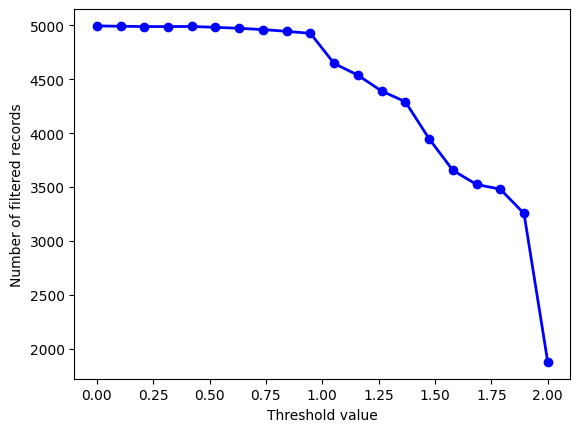

In [ ]:
x = count_data['T']
y = count_data['C']
plt.plot(x, y, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.xlabel('Threshold value')
plt.ylabel('Number of filtered records')
plt.show()

## **Wrapping Up: Merging Data and Keeping It Private** 🦾

In our digital world, the ability to merge and analyze different sets of information (or "data") to make smarter decisions is crucial. But, we can't forget about keeping that information safe and private. This notebook showed you how to do both.

Here's the simple breakdown:

1. We learned about **Record Linkage** - a cool technique for combining and matching data from various sources.
2. We examined different tools and strategies that can enhance the effectiveness of data merging.
3. Throughout the process, we made sure to protect the data's privacy using tools like **Differential Privacy** and the **Antigranular tool**.

Think of this as a recipe book: merging data is our main dish, and privacy is our secret ingredient. Remember, in the realm of data, success is not solely measured by the quantity of information, but also by how intelligently and securely it is utilised. Happy data blending! 🌪️